In [1]:
from __future__ import absolute_import
from IPython.display import clear_output
import json, os
from os.path import *
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from time import perf_counter
from BashColors import C
from TarfileFunctions import *
from CV2_Utils_2 import *

# import ImageClassifierDataLoader as icd
# from ImageClassifierDataLoader import *

import tensorflow as tf 
print(f'tensorflow version: {C.BIBlue}{tf.__version__}{C.ColorOff}')
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, initializers
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

from os.path import exists, join

contentPath = os.getcwd()
cv2Path=join(contentPath, 'CV2Images')
genPath=join(contentPath, 'DataGenerator')
testPath=join(contentPath, 'images')
checkpointPath = join(contentPath, 'CheckPoints')

if not exists(genPath):
    tff.extractTarfiles('DataGenerator5.tar.gz')
if not exists(testPath):
    tff.extractTarfiles('images.tar.gz')
    
initialGlobList:list
with open("initialGlobList.json", 'r') as f:
    initialGlobList = json.load(f)
    
def listNewFiles(initial=initialGlobList, delete=False):
    currentFilesGlob=glob.glob('**', recursive=False)
    print(f'New files...')
    if len(initialGlobList) == len(currentFilesGlob):
        print(f'{C.BIRed}No new files.\nNothing to see here.')
    for fil in currentFilesGlob:
        if not fil in initial:
            if isdir(fil):
                print(f'{C.BIBlue}{fil}')
                if delete:
                    shutil.rmtree(fil)
            elif isfile(fil):
                print(f'{C.ColorOff}{fil}')
                if delete:
                    os.remove(fil)
listNewFiles()

tensorflow version: 2.8.2
New files...


In [2]:
earlyStop = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', min_delta=0, patience=2, verbose=1,
    mode='auto', baseline=None, restore_best_weights=True,
)
checkpoints = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpointPath,
    monitor='accuracy', verbose=1, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch',
    options=None
)
print('ok')

ok


In [3]:
IMAGE_SIZE=(224, 224)
BATCH_SIZE = 32

import tensorflow
from tensorflow.keras.utils import image_dataset_from_directory
train_ds = image_dataset_from_directory(
    genPath,
    color_mode='rgb',
    validation_split=0.2,
    subset="training",
    seed=456,
    image_size=(224, 224),
    shuffle=True,
    batch_size=BATCH_SIZE)
print()

validation_ds = image_dataset_from_directory(
    genPath,
    color_mode='rgb',
    validation_split=0.2,
    subset="validation",
    seed=456,
    image_size=(224, 224),
    shuffle=True,
    batch_size=BATCH_SIZE)
print()

test_ds = image_dataset_from_directory(
    testPath,
    color_mode='rgb',
    image_size=(224, 224),
    shuffle=False,
    seed=456,
    batch_size = 1)
# clear_output()

TRAIN_STEPS = train_ds.cardinality().numpy() # 676 // BATCH_SIZE
print('\nTRAIN_STEPS:', TRAIN_STEPS)
VAL_STEPS = validation_ds.cardinality().numpy() # 168 // BATCH_SIZE
print('VAL_STEPS:', VAL_STEPS)

Found 844 files belonging to 3 classes.
Using 676 files for training.

Found 844 files belonging to 3 classes.
Using 168 files for validation.

Found 4 files belonging to 1 classes.

TRAIN_STEPS: 22
VAL_STEPS: 6


In [4]:
model = tf.keras.Sequential(name='Defcon4_Sequential_V8')
model.add(Conv2D(
    32, (3,3), activation='relu', input_shape=(224,224,3),
    kernel_initializer=initializers.RandomNormal(stddev=0.01),
    bias_initializer=initializers.Zeros()
))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
          
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

# model.add(Conv2D(128, (3,3), activation='relu'))
# model.add(MaxPooling2D(2,2))
# model.add(Conv2D(256, (3,3), activation='relu'))
# model.add(MaxPooling2D(2,2))
# model.add(Conv2D(512, (3,3), activation='relu'))
# model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu')) # hidden layer

model.add(Dense(512, activation='softmax'))

model.build()
model.summary()

Model: "Defcon4_Sequential_V8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        9280      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 

In [5]:
# learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False
myOptimizer = tf.keras.optimizers.RMSprop(
    learning_rate=0.005, rho=0.9, momentum=0.0, epsilon=1e-07,
    centered=False)

In [6]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = myOptimizer,
              metrics=['accuracy'])
model.built

True

In [7]:
startTimer=perf_counter()
history  =  model.fit(
    x = train_ds,
    y = None,
    batch_size = BATCH_SIZE,
    epochs = 10,
    verbose = 'auto',
    callbacks = [earlyStop, checkpoints],
    validation_split = 0.0,
    validation_data = validation_ds,
    shuffle = False,
    class_weight = None,
    sample_weight = None,
    initial_epoch = 0,
    steps_per_epoch = TRAIN_STEPS,
    validation_steps = VAL_STEPS,
    validation_batch_size = BATCH_SIZE,
    validation_freq = 1,
    max_queue_size = 6,
    workers = 4,
    use_multiprocessing = True,
)
finishTimer=perf_counter()
print()
cvu.printTime(startTimer, finishTimer)

Epoch 1/10
22/22 [==============================] - ETA: 0s - loss: 88.7920 - accuracy: 0.6198
Epoch 1: accuracy improved from -inf to 0.61982, saving model to /home/jovyan/CheckPoints
INFO:tensorflow:Assets written to: /home/jovyan/CheckPoints/assets
22/22 [==============================] - 102s 5s/step - loss: 88.7920 - accuracy: 0.6198 - val_loss: 0.3210 - val_accuracy: 0.8988
Epoch 2/10
22/22 [==============================] - ETA: 0s - loss: 0.2662 - accuracy: 0.9009
Epoch 2: accuracy improved from 0.61982 to 0.90089, saving model to /home/jovyan/CheckPoints
INFO:tensorflow:Assets written to: /home/jovyan/CheckPoints/assets
22/22 [==============================] - 95s 4s/step - loss: 0.2662 - accuracy: 0.9009 - val_loss: 0.3696 - val_accuracy: 0.9048
Epoch 3/10
22/22 [==============================] - ETA: 0s - loss: 0.5084 - accuracy: 0.8876
Epoch 3: accuracy did not improve from 0.90089
22/22 [==============================] - 94s 4s/step - loss: 0.5084 - accuracy: 0.8876 - val_

In [8]:
def plotShowTFLiteImagePredictions():
    ''' '''
    # https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/image_classifier/DataLoader
    # A helper function that returns 'red'/'black' depending on if its two input
    # parameter matches or not.
    def get_label_color(val1, val2):
        ''' '''
        if val1 == val2:
            return 'black'
        else:
            return 'red'

    # Then plot 100 test images and their predicted labels.
    # If a prediction result is different from the label provided label in "test"
    # dataset, we will highlight it in red color.
    plt.figure(figsize=(20, 20))
    predicts = model.predict_top_k(test_data)
    for i, (image, label) in enumerate(test_data.gen_dataset().unbatch().take(10)):
        ax = plt.subplot(10, 10, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image.numpy(), cmap=plt.cm.gray)
        predict_label = predicts[i][0][0]
        color = get_label_color(
            predict_label, test_data.index_to_label[label.numpy()])
        ax.xaxis.label.set_color(color)
        plt.xlabel('Predicted: %s' % predict_label)
    plt.show()
help(plotShowTFLiteImagePredictions)
# plotShowTFLiteImagePredictions()

Help on function plotShowTFLiteImagePredictions in module __main__:

plotShowTFLiteImagePredictions()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


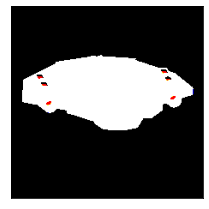

In [14]:
plt.figure(figsize=(12, 12))
for i, (image, label) in enumerate(test_ds.unbatch().take(1)):
  plt.subplot(3, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)
  # plt.xlabel(data.index_to_label[label.numpy()])
plt.show()

In [10]:
modelName = model.name + '_dnn.h5'
modelSavePath = join(contentPath, modelName)
print(f'model saved to: {modelSavePath}')
model.save(modelSavePath, overwrite=True)

model saved to: /home/jovyan/Defcon4_Sequential_V8_dnn.h5


In [11]:
newModelName = model.name + '.tflite'
# modelSavePath = join(contentPath, modelName)
print(f'newModelName: {C.BIPurple}{newModelName}{C.ColorOff}')

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(checkpointPath) # path to the SavedModel directory
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS
]
converter.optimizations=[tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the model.
with open(newModelName, 'wb') as f:
    f.write(tflite_model)
if exists(newModelName):
    print(f'saved: {C.BIGreen}{newModelName}')

newModelName: Defcon4_Sequential_V8.tflite
saved: Defcon4_Sequential_V8.tflite


In [12]:
listNewFiles()

New files...
Defcon4_Sequential_V8.tflite
CheckPoints
Defcon4_Sequential_V8_dnn.h5
